In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import pandas as pd
import seaborn as sns
import sys
sys.path.append("../")
import matplotlib.pyplot as plt
from curve_models import NLLS, NLLS_w, NLLS_rse, power_law, CurveModel, linearized_power_law
sns.set_style('white')
def calc_pct(pred_best, pred_worst, pred_curr):
    return (pred_worst - pred_curr)/(pred_worst - pred_best)

dataset_titles = {'gl': 'GoogleLocal-L', 'gl-tiny': 'GoogleLocal-S', 'ml-20m-tiny': 'MovieLens-S',
                 'ml-20m-uniform': 'MovieLens-L'}
gl_expmt = '5_False_0.1_0.4_uniform_29000_30_1_290001_5800_0_0.5_0.5_0_0.8'
ml_expmt = '5_False_0.1_0.4_uniform_100000_30_1_1000000_20000_0_0.5_0.5_0_0.8'
mltiny_expmt = '5_False_0.1_0.4_uniform_21000_5250_0_30_1_213973_0.5_0.5_0_0.85'
gltiny_expmt = '5_False_0.1_0.4_uniform_9400_30_1_94000_1880_0_0.5_0.5_0_0.8'
expmts = [('gl', gl_expmt), ('gl-tiny', gltiny_expmt), ('ml-20m-uniform', ml_expmt), ('ml-20m-tiny', mltiny_expmt)]
for dataset_name, expmt in expmts:
    results_path = '../results/forecasting/' + dataset_name + '/Random/' + expmt +'/'
    all_ss = np.loadtxt(results_path + 'sample_sizes')
    all_mses = np.loadtxt(results_path + 'mses')
    all_test_mses = np.loadtxt(results_path + 'test_mses')

    data = pd.read_csv(results_path + 'results_df')
    n_init = data['n_init'].iloc[0]
    n_observable = data['n_observable'].iloc[0]
    results = []
    n_runs = 5
    for j in range(n_runs):
        worst_mse = data[data['run'] == j]['worst_mse'].iloc[0]
        best_mse = data[data['run'] == j]['best_mse'].iloc[0]
        ss = all_ss[j]
        mses = all_mses[j]
        test_mses = all_test_mses[j]
        n_pts = len(np.where(ss) > n_init)
        for i, (size, mse) in enumerate(zip(ss, mses)):
            if size < n_init:
                continue
            
            pct_available = (size-n_init)/(n_observable-n_init)
            true_pct = (worst_mse - mse)/(worst_mse - best_mse)
            results.append({'pred_best': best_mse, 'pred_worst': worst_mse, 'pred_curr': mse,
                            'pred_pct': true_pct, 'true_curr': mse, 'cm': 'True', 'true_pct': true_pct, 
                            'pct_available': pct_available, 'run': j})

            # TODO: implement linear and init 
            results.append({'pred_best': best_mse, 'pred_worst': worst_mse, 'pred_curr': mse,
                            'pred_pct': (size-n_init)/(n_observable-n_init), 'true_curr': mse, 
                            'cm': 'Linear', 'true_pct': true_pct, 
                            'pct_available': pct_available, 'run': j})

            # initial
            nlls = NLLS(power_law)
            stop_pt = min(np.where(ss > n_init)[0])
            nlls.fit(ss[:stop_pt], mses[:stop_pt])
            pred_worst = nlls.f(n_init, **nlls.p)
            pred_best = nlls.f(n_observable, **nlls.p)
            pred_curr = nlls.f(size, **nlls.p)
            pred_pct = calc_pct(pred_best, pred_worst, pred_curr)
            results.append({'pred_best': pred_best, 'pred_worst': pred_worst, 'pred_curr': pred_curr,
                            'pred_pct': pred_pct, 'true_curr': mse, 'cm': 'NLS_initial', 'true_pct': true_pct, 
                            'pct_available': pct_available, 'run': j})

            # this baseline fits the power law curve to all points
            nlls = NLLS(power_law)
            nlls.fit(ss[:i+1], mses[:i+1])
            pred_worst = nlls.f(n_init, **nlls.p)
            pred_best = nlls.f(n_observable, **nlls.p)
            pred_curr = nlls.f(size, **nlls.p)
            pred_pct = calc_pct(pred_best, pred_worst, pred_curr)
            results.append({'pred_best': pred_best, 'pred_worst': pred_worst, 'pred_curr': pred_curr,
                            'pred_pct': pred_pct, 'true_curr': mse, 'cm': 'NLS', 'true_pct': true_pct, 
                            'pct_available': pct_available, 'run': j})

            # this method fits the weighted power law curve to all pts
            nlls_w = NLLS_w(power_law)
            nlls_w.fit(ss[:i+1], mses[:i+1])
            pred_worst = nlls_w.f(n_init, **nlls_w.p)
            pred_best = nlls_w.f(n_observable, **nlls_w.p)
            pred_curr = nlls_w.f(size, **nlls_w.p)
            pred_pct = calc_pct(pred_best, pred_worst, pred_curr)
            results.append({'pred_best': pred_best, 'pred_worst': pred_worst, 'pred_curr': pred_curr,
                            'pred_pct': pred_pct, 'true_curr': mse, 'cm': 'NLS_w', 'true_pct': true_pct, 
                            'pct_available': pct_available, 'run': j})
            # this method fits a beginning power law curve and an end one
            start_cm = NLLS_rse(linearized_power_law)
            start = 0
            end = np.min([9, i+1])
            end = int(i/2)
            start_cm.fit(ss[start:end], mses[start:end])

            end_cm = NLLS_rse(linearized_power_law)
            start = int(i/2)
            end_cm.fit(ss[start:i+1], mses[start:i+1])

            pred_worst = start_cm.f(n_init, **start_cm.p)
            pred_best = end_cm.f(n_observable, **end_cm.p)
            pred_curr = end_cm.f(size, **end_cm.p)
            pred_pct = calc_pct(pred_best, pred_worst, pred_curr)
            results.append({'pred_best': pred_best, 'pred_worst': pred_worst, 'pred_curr': pred_curr,
                            'pred_pct': pred_pct, 'true_curr': mse, 'cm': 'NLS_mix', 'true_pct': true_pct, 
                            'pct_available': pct_available, 'run': j})

        print('saving!')
        pd.DataFrame(results).to_csv('../results/forecasting/' + dataset_name + '/pred_performance')

saving!
saving!
saving!
saving!
saving!
saving!
saving!
saving!
saving!
saving!
saving!
saving!
saving!
saving!
saving!


/local/divyas/.conda/envs/uncertainty/lib/python3.7/site-packages/statsmodels/regression/linear_model.py:1578: RuntimeWarning: divide by zero encountered in double_scalars
  return np.dot(wresid, wresid) / self.df_resid
/local/divyas/.conda/envs/uncertainty/lib/python3.7/site-packages/statsmodels/regression/linear_model.py:1648: RuntimeWarning: divide by zero encountered in true_divide
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
/local/divyas/.conda/envs/uncertainty/lib/python3.7/site-packages/statsmodels/regression/linear_model.py:1649: RuntimeWarning: invalid value encountered in double_scalars
  * (1 - self.rsquared))


saving!
saving!
saving!
saving!
saving!


In [2]:
all_results = []
for i, (dataset_name, _) in enumerate(expmts):
    results_df = pd.read_csv('../results/forecasting/' + dataset_name + '/pred_performance')
    results_df = results_df.round({'pred_pct': 2, 'true_pct': 2})
    results_df['dataset'] = dataset_name
    print(len(results_df))
    all_results.append(results_df)
all_results = pd.concat(all_results)

1500
1500
1500
1230


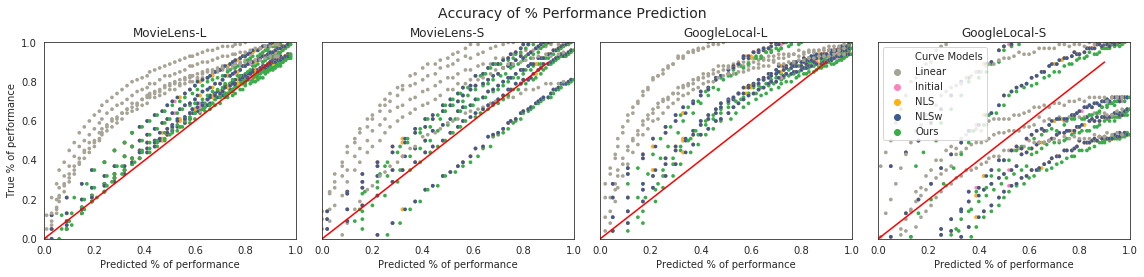

In [3]:
expmts = [('ml-20m-uniform', ml_expmt), ('ml-20m-tiny', mltiny_expmt), ('gl', gl_expmt), ('gl-tiny', gltiny_expmt)]
with sns.xkcd_palette(["greyish", "pink", "amber", "denim blue", "medium green"]):
    fig, axs = plt.subplots(1, 4, sharex=True, sharey=True, figsize=(16, 4))

    for i, (dataset_name, _) in enumerate(expmts):
        #ax = axs[int(i/2), i%2]
        ax = axs[i]
        hue_order = ['Linear', 'NLS_initial', 'NLS', 'NLS_w', 'NLS_mix']
        results_df = pd.read_csv('../results/forecasting/' + dataset_name + '/pred_performance')
        results_df = results_df.round({'pred_pct': 2, 'true_pct': 2})
        results_df['dataset'] = dataset_name
        cm_results = results_df[results_df['cm'] != 'True']
        sns.scatterplot(x='pred_pct', y='true_pct', data=cm_results, hue='cm', hue_order=hue_order, s=14,
                         linewidth=0, ax=ax)
        ax.plot([i for i in np.arange(0, 1, .1)], [i for i in np.arange(0, 1, .1)], c='r', label='True')
        ax.set_xlim(0, 1)
        ax.set_ylim(0, 1)
        ax.set_ylabel("True % of performance")
        ax.set_xlabel("Predicted % of performance")
        if i != 3:
            ax.get_legend().remove()
        else:
            L=ax.get_legend()
            new_names = ['Curve Models', 'Linear', 'Initial', 'NLS', 'NLSw', 'Ours']
            for i,new in enumerate(new_names):
                L.get_texts()[i].set_text(new)
        ax.set_title(dataset_titles[dataset_name])
plt.suptitle("Accuracy of % Performance Prediction", fontsize=14)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig('../figs/performance_pred.png')

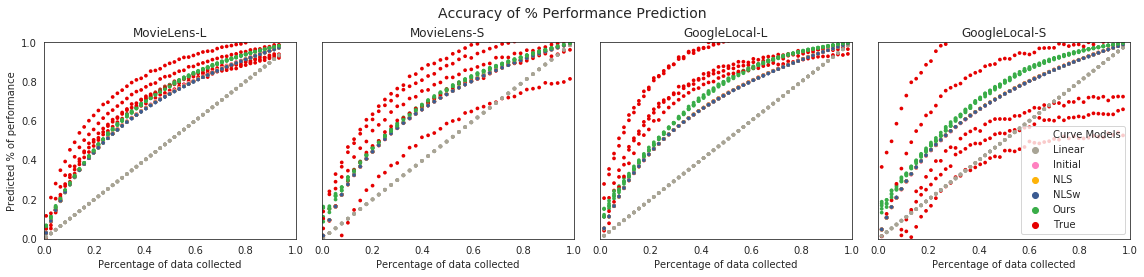

In [4]:
sns.set_style('white')
expmts = [('ml-20m-uniform', ml_expmt), ('ml-20m-tiny', mltiny_expmt), ('gl', gl_expmt), ('gl-tiny', gltiny_expmt)]
with sns.xkcd_palette(["greyish", "pink", "amber", "denim blue", "medium green", "red"]):
    fig, axs = plt.subplots(1, 4, sharex=True, sharey=True, figsize=(16, 4))

    for i, (dataset_name, _) in enumerate(expmts):
        #ax = axs[int(i/2), i%2]
        ax  = axs[i]
        hue_order = ['Linear', 'NLS_initial', 'NLS', 'NLS_w', 'NLS_mix', 'True']
        results_df = pd.read_csv('../results/forecasting/' + dataset_name + '/pred_performance')
        results_df = results_df.round({'pred_pct': 4, 'true_pct': 4})
        #cm_results = results_df[results_df['cm'] != 'True']
        sns.scatterplot(x='pct_available', y='pred_pct', data=results_df, hue='cm', hue_order=hue_order, s=14,
                          linewidth=0, ax=ax)
        ax.set_xlim(0, 1)
        ax.set_ylim(0, 1)
        ax.set_ylabel("Predicted % of performance")
        ax.set_xlabel("Percentage of data collected")
        if i != 3:
            ax.get_legend().remove()
        else:
            L=ax.get_legend()
            new_names = ['Curve Models', 'Linear', 'Initial', 'NLS', 'NLSw', 'Ours']
            for i,new in enumerate(new_names):
                L.get_texts()[i].set_text(new)
        ax.set_title(dataset_titles[dataset_name])
plt.suptitle("Accuracy of % Performance Prediction", fontsize=14)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig('../figs/performance_pred_v_pct_available.png')

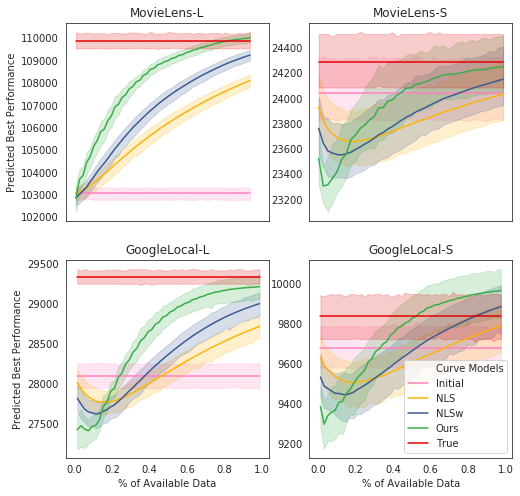

In [6]:
# plot best_mse prediction over pct_available
fig, axs = plt.subplots(2, 2, sharex=True, figsize=(8, 8))
hue_order = ['NLS_initial', 'NLS', 'NLS_w', 'NLS_mix', 'True']
with sns.xkcd_palette(["pink", "amber", "denim blue", "medium green", "red"]):
    for i, (dataset_name, _) in enumerate(expmts):

        ax = axs[int(i/2), i%2]
        forecasting_cms = all_results[all_results['cm'] !='Linear']
        dataset_results = forecasting_cms[forecasting_cms['dataset'] == dataset_name]
        sns.lineplot(x='pct_available', y='pred_best', hue='cm', data=dataset_results, ax=ax, hue_order=hue_order)
        ax.set_title(dataset_titles[dataset_name])
        if i == 0 or i == 2:
            ax.set_ylabel("Predicted Best Performance")
        else:
            ax.set_ylabel("")
        
        if i == 2 or i == 3:
            ax.set_xlabel("% of Available Data")
        else:
            ax.set_xlabel("")
        if i != 3:
            ax.get_legend().remove()
        else:
            L=ax.get_legend()
            new_names = ['Curve Models', 'Initial', 'NLS', 'NLSw', 'Ours']
            for i,new in enumerate(new_names):
                L.get_texts()[i].set_text(new)
        plt.savefig('../figs/pred_best_performance.png')

In [89]:
dataset_name = 'gl-tiny'
results_path = '../results/forecasting/' + dataset_name + '/Random/' + gltiny_expmt +'/'
all_ss = np.loadtxt(results_path + 'sample_sizes')
all_mses = np.loadtxt(results_path + 'mses')
all_test_mses = np.loadtxt(results_path + 'test_mses')
#all_user_mses = np.load(results_path + 'macro_mses.npy')

data = pd.read_csv(results_path + 'results_df')

In [90]:
[data[data['run'] == i]['best_mse'].iloc[0] for i in range(5)]

[9727.041451627629,
 9650.001075051412,
 9995.689232263383,
 9856.035303291232,
 9942.476039479665]

In [92]:
set(all_results[(all_results['run'] == i) & ((all_results['run'] == i) & all_results['cm'] == 'True') &
                (all_results['dataset'] == 'gl-tiny')]['pred_best'])

{9995.689232263383}

In [28]:
 results_df = pd.read_csv('../results/forecasting/' + dataset_name + '/pred_performance')
results_df[results_df['cm'] == 'True']

,Unnamed: 0,pred_best,pred_worst,pred_curr,pred_pct,true_curr,cm,true_pct,pct_available,run
0,0,9995.689232,11022.597803,10921.605410,0.098346,10921.605410,True,0.098346,0.013835,0
6,6,9995.689232,11022.597803,10797.681084,0.219023,10797.681084,True,0.219023,0.033422,0
12,12,9995.689232,11022.597803,10732.470176,0.282525,10732.470176,True,0.282525,0.053008,0
18,18,9995.689232,11022.597803,10653.742367,0.359190,10653.742367,True,0.359190,0.072594,0
24,24,9995.689232,11022.597803,10593.822750,0.417540,10593.822750,True,0.417540,0.092180,0
...,...,...,...,...,...,...,...,...,...,...
1470,1470,9995.689232,11022.597803,9940.215015,1.054021,9940.215015,True,1.054021,0.895214,4
1476,1476,9995.689232,11022.597803,9935.297027,1.058810,9935.297027,True,1.058810,0.914800,4
1482,1482,9995.689232,11022.597803,9931.089385,1.062907,9931.089385,True,1.062907,0.934386,4
1488,1488,9995.689232,11022.597803,9936.014561,1.058111,9936.014561,True,1.058111,0.953972,4


In [23]:
all_results[(all_results['dataset'] == 'ml-20m-tiny') & (all_results['cm'] == True)]

,Unnamed: 0,pred_best,pred_worst,pred_curr,pred_pct,true_curr,cm,true_pct,pct_available,run,dataset


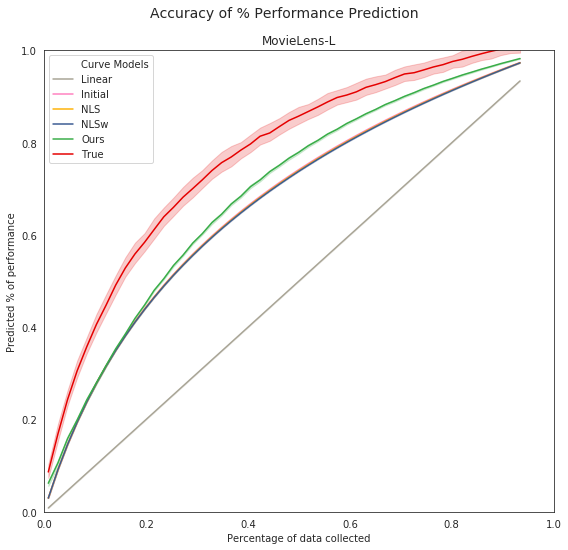

In [9]:
with sns.xkcd_palette(["greyish", "pink", "amber", "denim blue", "medium green", "red"]):
    fig, ax = plt.subplots(1, 1, sharex=True, sharey=True, figsize=(8, 8))

    for i, (dataset_name, _) in enumerate(expmts):
        if dataset_name != 'ml-20m-uniform':
            continue
        hue_order = ['Linear', 'NLS_initial', 'NLS', 'NLS_w', 'NLS_mix', 'True']
        results_df = pd.read_csv('../results/forecasting/' + dataset_name + '/pred_performance')
        results_df = results_df.round({'pred_pct': 4, 'true_pct': 4})
        #cm_results = results_df[results_df['cm'] != 'True']
        sns.lineplot(x='pct_available', y='pred_pct', data=results_df, hue='cm', hue_order=hue_order, ax = ax)
                         #s=14, linewidth=0
        ax.set_xlim(0, 1)
        ax.set_ylim(0, 1)
        ax.set_ylabel("Predicted % of performance")
        ax.set_xlabel("Percentage of data collected")

        L=ax.get_legend()
        new_names = ['Curve Models', 'Linear', 'Initial', 'NLS', 'NLSw', 'Ours']
        for i,new in enumerate(new_names):
            L.get_texts()[i].set_text(new)
        ax.set_title(dataset_titles[dataset_name])
plt.suptitle("Accuracy of % Performance Prediction", fontsize=14)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig('../figs/performance_pred_v_pct_available.png')

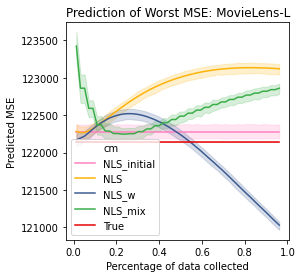

In [581]:
# plot best_mse prediction over pct_available
fig, ax = plt.subplots(1, 1, sharex=True, figsize=(4, 4))
hue_order = ['NLS_initial', 'NLS', 'NLS_w', 'NLS_mix', 'True']
dataset_name = 'ml-20m-uniform'
yname = 'pred_worst'
with sns.xkcd_palette(["pink", "amber", "denim blue", "medium green", "red"]):
        forecasting_cms = all_results[all_results['cm'] !='Linear']
        dataset_results = forecasting_cms[forecasting_cms['dataset'] == dataset_name]
        
        sns.lineplot(x='pct_available', y=yname, hue='cm', data=dataset_results, ax=ax, hue_order=hue_order)
        plt.xlabel("Percentage of data collected")
        plt.ylabel("Predicted MSE")
        if 'best' in yname:
            plt.title("Prediction of Best MSE: " + dataset_titles[dataset_name])
            L=ax.get_legend()
            new_names = ['Curve Models', 'Initial', 'NLS', 'NLSw', 'Ours']
            for i,new in enumerate(new_names):
                L.get_texts()[i].set_text(new)
        else:
            plt.title("Prediction of Worst MSE: " + dataset_titles[dataset_name])

        

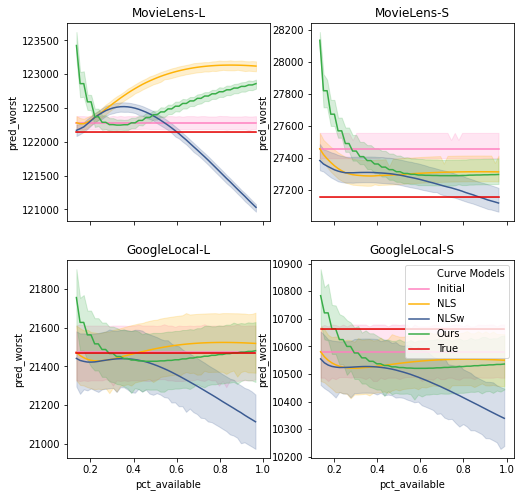

In [510]:
# plot best_mse prediction over pct_available
fig, axs = plt.subplots(2, 2, sharex=True, figsize=(8, 8))
hue_order = ['NLS_initial', 'NLS', 'NLS_w', 'NLS_mix', 'True']
with sns.xkcd_palette(["pink", "amber", "denim blue", "medium green", "red"]):
    for i, (dataset_name, _) in enumerate(expmts):
        ax = axs[int(i/2), i%2]
        forecasting_cms = all_results[all_results['cm'] !='Linear']
        dataset_results = forecasting_cms[forecasting_cms['dataset'] == dataset_name]
        sns.lineplot(x='pct_available', y='pred_worst', hue='cm', data=dataset_results, ax=ax, hue_order=hue_order)
        ax.set_title(dataset_titles[dataset_name])
        if i != 3:
            ax.get_legend().remove()
        else:
            L=ax.get_legend()
            new_names = ['Curve Models', 'Initial', 'NLS', 'NLSw', 'Ours']
            for i,new in enumerate(new_names):
                L.get_texts()[i].set_text(new)

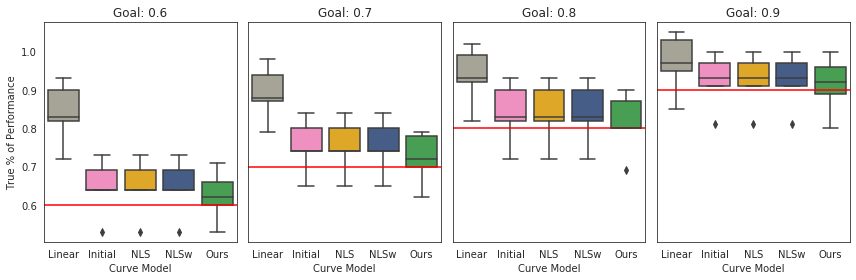

In [20]:
# Plot stopping criterions
goals = [.6, .7, .8, .9]
fig, axs = plt.subplots(1, 4, sharex=True, sharey=True, figsize=(12, 4))
dataset_name = 'ml-20m-tiny'
with sns.xkcd_palette(["greyish", "pink", "amber", "denim blue", "medium green", "red"]):
    for i, g in enumerate(goals):
        ax = axs[i]
        test_df = all_results[all_results['pred_pct'] > g]
        test_df = test_df[test_df['cm'] != 'True']
        draw_df = test_df.sort_values('pred_pct').groupby(['cm', 'run', 'dataset']).first().reset_index()
        dataset_df = draw_df[draw_df['dataset'] == dataset_name]
        sns.boxplot(x='cm', y='true_pct', data=dataset_df, ax=ax,
                    order=['Linear', 'NLS_initial', 'NLS', 'NLS_w', 'NLS_mix'])
        ax.set_xticklabels(['Linear', 'Initial', 'NLS', 'NLSw', 'Ours'])
        ax.axhline(y=g, c='r', label='Goal')
        ax.set_xlabel("Curve Model")
        ax.set_ylabel("True % of Performance")
        ax.set_title("Goal: " + str(g))
        if i > 0:
            ax.set_ylabel("")
        plt.savefig('../figs/' + dataset_name + '_stopping_criterion.png')
plt.tight_layout()
# Filter pred_pct for being greater than goal percentage g 
# Choose the minimum entry, record true percentage
# For a given goal percentage g, at what point do different algorithms stop? 

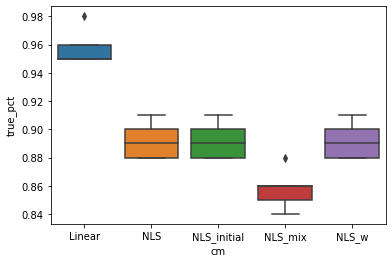

In [535]:
goals = [.8, .85, .9, .95]
g = .8



In [623]:
# initial
expmt  = '5_False_0.1_0.4_uniform_100000_30_1_1000000_20000_0_0.5_0.5_0_0.8'
dataset_name = 'ml-20m-uniform'
results_path = '../results/forecasting/' + dataset_name + '/Random/' + expmt +'/'
all_ss = np.loadtxt(results_path + 'sample_sizes')
all_mses = np.loadtxt(results_path + 'mses')
nlls_i = NLLS(power_law)
stop_pt = min(np.where(ss > n_init)[0])
nlls_i.fit(ss[:9], mses[:9])
pred_worst = nlls_i.f(n_init, **nlls_i.p)
pred_best = nlls_i.f(n_observable, **nlls_i.p)
pred_curr = nlls_i.f(size, **nlls_i.p)
pred_pct = calc_pct(pred_best, pred_worst, pred_curr)
print(pred_pct)
results.append({'pred_best': pred_best, 'pred_worst': pred_worst, 'pred_curr': pred_curr,
                'pred_pct': pred_pct, 'true_curr': mse, 'cm': 'NLS_initial', 'true_pct': true_pct, 
                'pct_available': pct_available, 'run': j})

# this baseline fits the power law curve to all points
nlls = NLLS(power_law)
nlls.fit(ss[:20], mses[:20])
pred_worst = nlls.f(n_init, **nlls.p)
pred_best = nlls.f(n_observable, **nlls.p)
pred_curr = nlls.f(size, **nlls.p)
pred_pct = calc_pct(pred_best, pred_worst, pred_curr)
print(pred_pct)
results.append({'pred_best': pred_best, 'pred_worst': pred_worst, 'pred_curr': pred_curr,
                'pred_pct': pred_pct, 'true_curr': mse, 'cm': 'NLS', 'true_pct': true_pct, 
                'pct_available': pct_available, 'run': j})

# this method fits the weighted power law curve to all pts
nlls_w = NLLS_w(power_law)
nlls_w.fit(ss[:20], mses[:20])
pred_worst = nlls_w.f(n_init, **nlls_w.p)
pred_best = nlls_w.f(n_observable, **nlls_w.p)
pred_curr = nlls_w.f(size, **nlls_w.p)
pred_pct = calc_pct(pred_best, pred_worst, pred_curr)
print(pred_pct)
results.append({'pred_best': pred_best, 'pred_worst': pred_worst, 'pred_curr': pred_curr,
                'pred_pct': pred_pct, 'true_curr': mse, 'cm': 'NLS_w', 'true_pct': true_pct, 
                'pct_available': pct_available, 'run': j})

[[2.69665744e-10 1.59100035e-04]
 [1.59100035e-04 9.43716422e+01]]
0.9830135490386372
[[9.43575150e-11 6.24037437e-05]
 [6.24037437e-05 4.15519282e+01]]
0.9831061874827484
0.9831626674414536


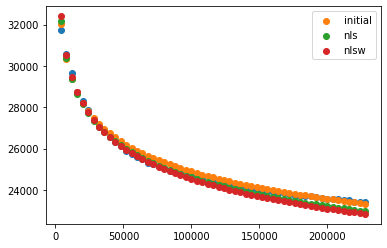

In [622]:
plt.scatter(ss, mses)
plt.scatter(ss, [nlls_i.f(s, **nlls_i.p) for s in ss], label='initial')
plt.scatter(ss, [nlls.f(s, **nlls.p) for s in ss], label='nls')
plt.scatter(ss, [nlls_w.f(s, **nlls_w.p) for s in ss], label='nlsw')
plt.legend()

In [7]:
g = .8
dataset_name = 'ml-tiny'

test_df = all_results[all_results['pred_pct'] > g]
test_df = test_df[test_df['cm'] != 'True']
draw_df = test_df.sort_values('pred_pct').groupby(['cm', 'run', 'dataset']).first().reset_index()
dataset_df = draw_df[draw_df['dataset'] == dataset_name]
ours_df = dataset_df[dataset_df['cm'] == 'NLS_mix']

In [13]:
all_results.keys()

Index(['Unnamed: 0', 'pred_best', 'pred_worst', 'pred_curr', 'pred_pct',
       'true_curr', 'cm', 'true_pct', 'pct_available', 'run', 'dataset'],
      dtype='object')

In [ ]:
f